<a href="https://colab.research.google.com/github/cosminnedescu/ProjectMLDL/blob/main/baselines/FineTuning-group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, DataLoader

from PIL import Image

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from copy import copy


#### Cloning the Git repository

In [2]:
!rm -rf ProjectMLDL
if not os.path.isdir('/content/ProjectMLDL'):
  !git clone https://github.com/cosminnedescu/ProjectMLDL.git
  %cd /content/ProjectMLDL
  !rm -rf LICENSE README.md

Cloning into 'ProjectMLDL'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 150 (delta 55), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (150/150), 227.73 KiB | 6.70 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/ProjectMLDL


In [3]:
from data.cifar100 import CIFAR100
from model.resnet32 import resnet32
import data.utils
from model.trainer import Trainer

#### Downloading data from Cifar100

In [4]:
# True mean and std of Cifar100 dataset (src="https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151")
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(mean, std),
     ])

In [5]:
train_data = CIFAR100("dataset", train=True, transform=train_transform, download=True)
test_data = CIFAR100("dataset", train=False, transform=test_transform, download=True)

Extracting dataset/cifar-100-python.tar.gz to dataset
Files already downloaded and verified



classe: 90


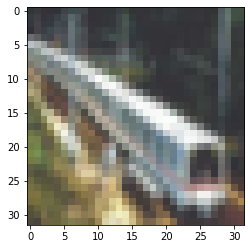

In [6]:
#check images and labels after shuffle
#https://github.com/keras-team/keras/issues/2653#issuecomment-450133996
import matplotlib.pyplot as plt

plt.imshow(train_data.data[6])
print("classe: {}".format(train_data.targets[6]))

### Defining hyperparameters according to iCarl paper

In [7]:
RANDOM_SEED = [42,13,10]
# Settings
DEVICE = 'cuda'

NUM_CLASSES = 100       # Total number of classes

VAL_SIZE = 0.1          # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 128        # Batch size
LR = 2               # Initial learning rate
                       
MOMENTUM = 0.9          # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5     # Weight decay from iCaRL

NUM_RUNS = 3            # Number of runs of every method
                        # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70         # Total number of training epochs
MILESTONES = [49, 63]   # Step down policy from iCaRL (MultiStepLR)
                        # Decrease the learning rate by gamma at each milestone
GAMMA = 0.2             # Gamma factor from iCaRL

## Fine Tuning

### Definition of `do_shuffle` and `do_group_classes`



`do_shuffle` and `do_group_classes` are two functions that rispectively shuffle data downloaded from Cifar100 and get the incremental classes division for the incremental learning phase.

In [8]:
def do_shuffle(train_d, test_d):
  train_d.__shuffle_seed__(RANDOM_SEED[run])
  test_d.__shuffle_seed__(RANDOM_SEED[run])
  return train_d, test_d

def do_group_classes(train_d, test_d):
  indexes_train_data = train_d.__incremental_indexes__(True)
  indexes_test_data = test_d.__incremental_indexes__(False)


  train_dataloader = [[] for i in range(10)]
  val_dataloader = [[] for i in range(10)]
  test_dataloader = [[] for i in range(10)]
  for i in range(10):
    train_dataset = Subset(train_d, indexes_train_data[i])
    train_set, val_set = torch.utils.data.random_split(train_dataset, [int(0.8*len(indexes_train_data[0])), int(0.2*len(indexes_train_data[0]))])
    tmp_dl = DataLoader(train_set, 
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        drop_last=True)
    train_dataloader[i] = copy(tmp_dl) # gruppi di 10 classi 
    tmp_dl = DataLoader(val_set, 
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        drop_last=True)
    val_dataloader[i] = copy(tmp_dl) # gruppi di 10 classi


    test_dataset = Subset(test_d, indexes_test_data[i])
    tmp_dl = DataLoader(test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        drop_last=True)
    test_dataloader[i] = copy(tmp_dl) # classi incrementali: 0:0-9, 1:0-19, 2:0-29, ..., 9:0-99
    
  return train_dataloader, val_dataloader, test_dataloader

### Going on with the model

This is the main FineTuning step.

This step is run 3 times with different `RANDOM_SEED`.
Here the model is instantiated, trained and tested.

Results and some statistics are then stored in the variable `logs`.


In [9]:
logs = [{'all_class_preds': [], 
         'acc_test': [], 
         'true_lbls': [],
         'epochs_losses': []} for i in range(len(RANDOM_SEED))]

for run in range(len(RANDOM_SEED)):
  print("#################################")
  print(f"Radom seed: {RANDOM_SEED[run]}")
  print("")



  #shuffle data
  tain_data, test_data = do_shuffle(train_data, test_data)
  #get dataloader separated in incremental groups of 10 classes
  train_dl, val_dl, test_dl = do_group_classes(train_data, test_data)

  #create the resnet
  net = resnet32()

  #define criterion, parameters, optimizer and scheduler
  criterion = nn.BCEWithLogitsLoss()
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA)
  
  #create instance of the trainer.class
  trainer = Trainer(
      device = DEVICE,
      net = net,
      criterion = criterion,
      optimizer = optimizer,
      scheduler = scheduler,
      train_dl = train_dl,
      validation_dl = val_dl,
      test_dl = test_dl
  )

  #try different num_epochs
  num_epochs = 80

  #train and evaluate the model
  logs[run]['epochs_losses'], logs[run]['acc_test'], logs[run]['true_lbls'], logs[run]['preds']  = trainer.train_model(num_epochs)



  print("#################################")
  print("")
  print("")

#################################
Radom seed: 42



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Output streaming troncato alle ultime 5000 righe.
Epoch[25] loss: 0.36383450896509234 LR: [0.08000000000000002]
Validation on group[8] of 10 classes
val loss: 0.3640578942639487
val acc: 0.0

Epoch[26] loss: 0.36340897698556224 LR: [0.08000000000000002]
Validation on group[8] of 10 classes
val loss: 0.3630843758583069
val acc: 0.0

Epoch[27] loss: 0.36298000235711375 LR: [0.08000000000000002]
Validation on group[8] of 10 classes
val loss: 0.3638358201299395
val acc: 0.0

Epoch[28] loss: 0.3626084462288887 LR: [0.08000000000000002]
Validation on group[8] of 10 classes
val loss: 0.36321926968438284
val acc: 0.0

Epoch[29] loss: 0.3622258497822669 LR: [0.08000000000000002]
Validation on group[8] of 10 classes
val loss: 0.36145901679992676
val acc: 0.0

Epoch[30] loss: 0.36187856524221357 LR: [0.08000000000000002]
Validation on group[8] of 10 classes
val loss: 0.36222265873636517
val acc: 0.0

Epoch[31] loss: 0.3615460914950217 LR: [0.08000000000000002]
Validation on group[8] of 10 classes

### Print some graphs

In [10]:
#da sistemare
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plotConfusionMatrix(confusionMatrixData, seed):
	fig,ax=plt.subplots(figsize=(10,10))
	sns.heatmap(confusionMatrixData,cmap='terrain',ax=ax)
	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.title("Confusion Matrix - seed: {}".format(seed))

	#filename = "cm_{}_{}.jpg".format(method, seed) # ex. cm_lwf_30
	#plt.savefig(filename, format='png', dpi=300)
	plt.show()
 
 
t = all_targets.cpu().data.numpy()
p = all_preds.cpu().data.numpy()
confusionMatrixData = confusion_matrix(t, p)
plotConfusionMatrix(confusionMatrixData, RANDOM_SEED[0])


NameError: ignored